Step 1: Load CIFAR-10 Data and Pretrained ResNet-20



100%|██████████| 170M/170M [00:05<00:00, 31.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


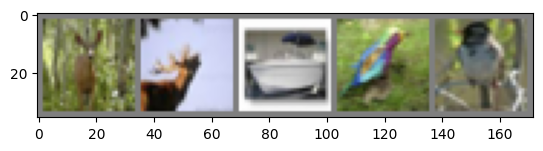

Labels: [4, 4, 8, 2, 2]


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 14.3MB/s

Accuracy of the ResNet-20 model on CIFAR-10 test data: 81.13%


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:5]))
print('Labels:', labels[:5].tolist())

target_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
target_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = target_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the ResNet-20 model on CIFAR-10 test data: {100 * correct / total:.2f}%')

In [4]:
! pip install cleverhans -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.7 MB/s eta 0:00:00


Generate Adversarial Images Using CleverHans

Adversarial Attack Success Rate: 63.17%


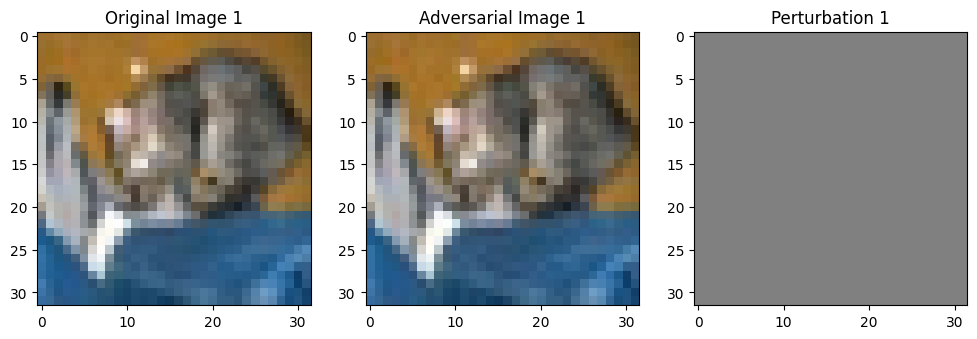

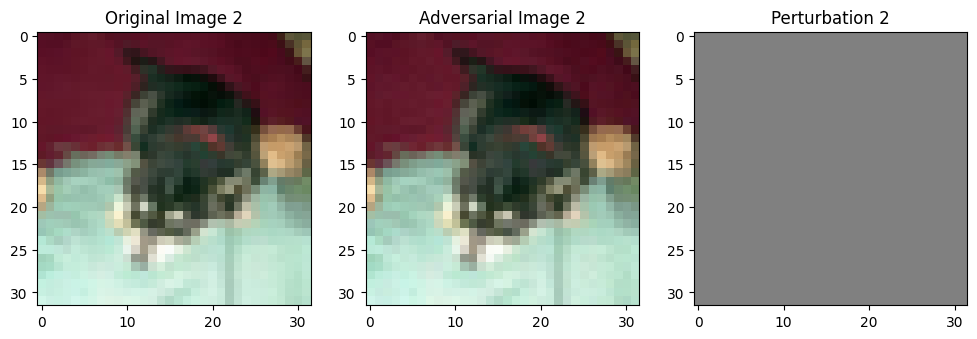

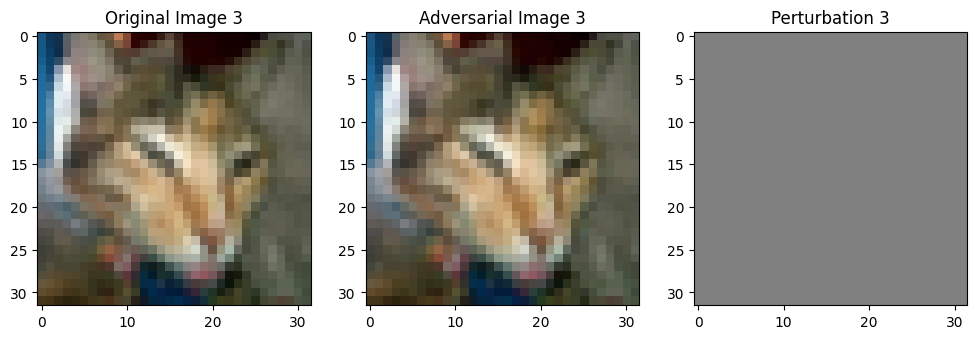

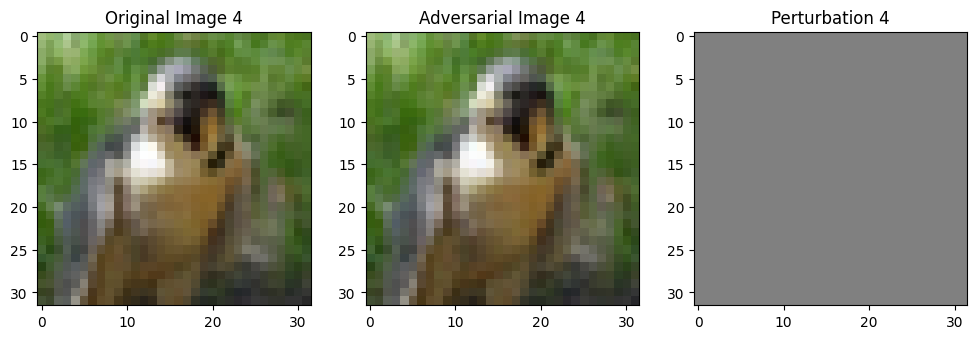

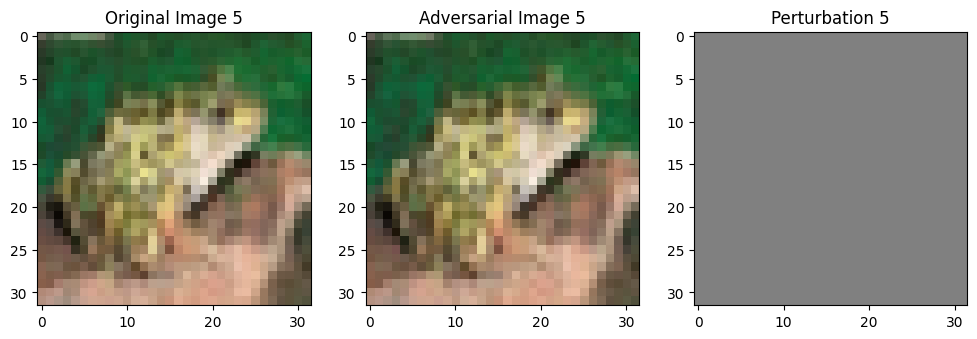

In [3]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

epsilon = 0.01

attack_success = 0
total = 0
original_images, adversarial_images, perturbations = [], [], []

for i, (images, labels) in enumerate(testloader):
    images, labels = images, labels
    adv_images = fast_gradient_method(target_model, images, epsilon, np.inf)

    original_pred = target_model(images).argmax(1)
    adv_pred = target_model(adv_images).argmax(1)
    attack_success += (adv_pred != labels).sum().item()
    total += labels.size(0)

    if i < 5:
        original_images.append(images[0])
        adversarial_images.append(adv_images[0])
        perturbations.append((adv_images[0] - images[0]).abs())

success_rate = (attack_success / total) * 100
print(f'Adversarial Attack Success Rate: {success_rate:.2f}%')

def show_images(original, adversarial, perturbation, index):
    original = original.detach().cpu() / 2 + 0.5
    adversarial = adversarial.detach().cpu() / 2 + 0.5
    perturbation = perturbation.detach().cpu() / 2 + 0.5

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(np.transpose(original.numpy(), (1, 2, 0)))
    axes[0].set_title(f"Original Image {index+1}")
    axes[1].imshow(np.transpose(adversarial.numpy(), (1, 2, 0)))
    axes[1].set_title(f"Adversarial Image {index+1}")
    axes[2].imshow(np.transpose(perturbation.numpy(), (1, 2, 0)))
    axes[2].set_title(f"Perturbation {index+1}")
    plt.show()

for i in range(5):
    show_images(original_images[i], adversarial_images[i], perturbations[i], i)

Adversarial Attack Success Rate: 87.93%


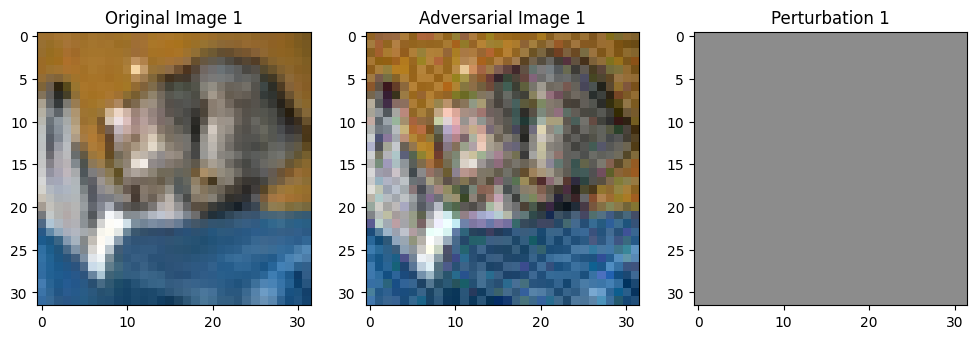

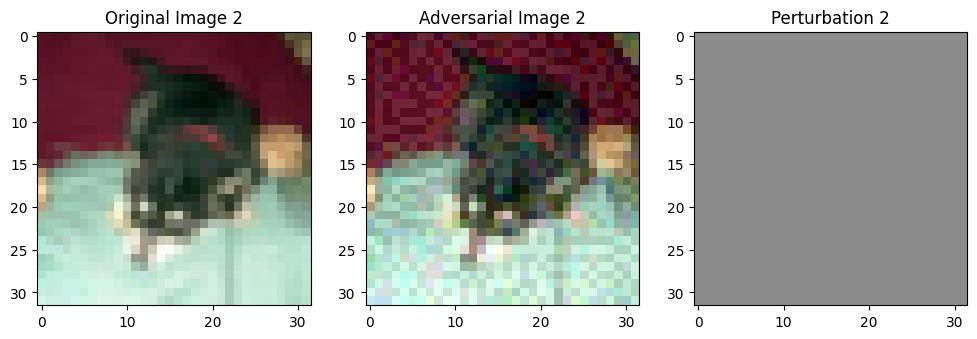

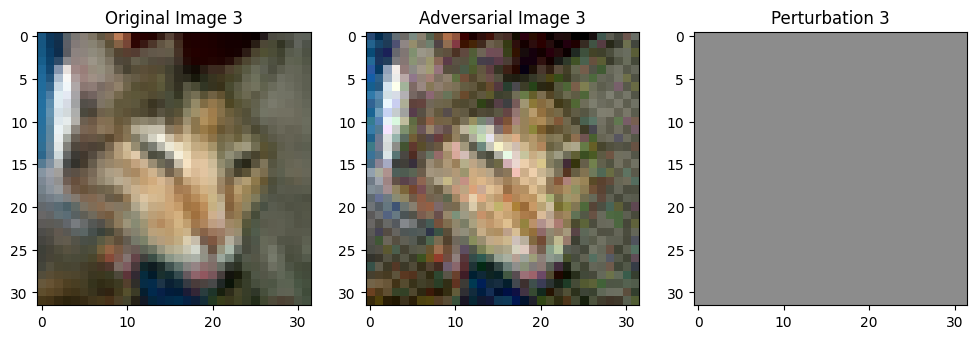

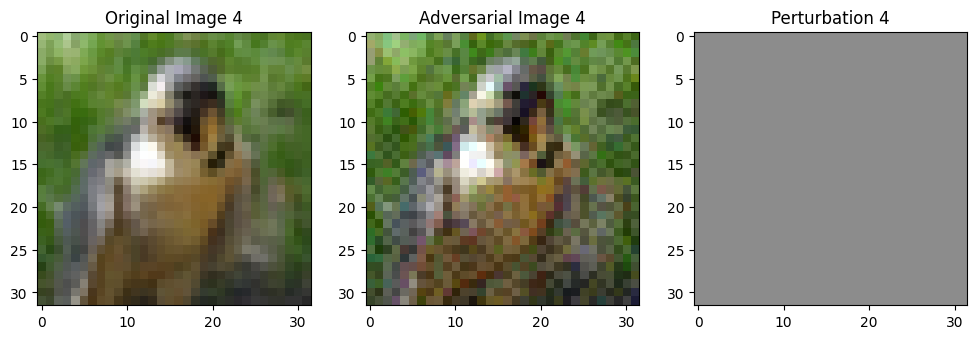

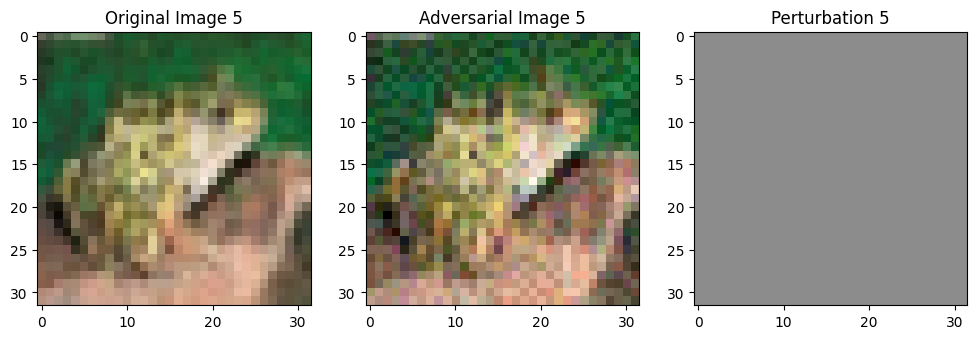

In [5]:
'''
epsilon = 0.1

attack_success = 0
total = 0
original_images, adversarial_images, perturbations = [], [], []

for i, (images, labels) in enumerate(testloader):
    images, labels = images, labels
    adv_images = fast_gradient_method(target_model, images, epsilon, np.inf)

    original_pred = target_model(images).argmax(1)
    adv_pred = target_model(adv_images).argmax(1)
    attack_success += (adv_pred != labels).sum().item()
    total += labels.size(0)

    if i < 5:
        original_images.append(images[0])
        adversarial_images.append(adv_images[0])
        perturbations.append((adv_images[0] - images[0]).abs())

success_rate = (attack_success / total) * 100
print(f'Adversarial Attack Success Rate: {success_rate:.2f}%')

def show_images(original, adversarial, perturbation, index):
    original = original.detach().cpu() / 2 + 0.5
    adversarial = adversarial.detach().cpu() / 2 + 0.5
    perturbation = perturbation.detach().cpu() / 2 + 0.5

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(np.transpose(original.numpy(), (1, 2, 0)))
    axes[0].set_title(f"Original Image {index+1}")
    axes[1].imshow(np.transpose(adversarial.numpy(), (1, 2, 0)))
    axes[1].set_title(f"Adversarial Image {index+1}")
    axes[2].imshow(np.transpose(perturbation.numpy(), (1, 2, 0)))
    axes[2].set_title(f"Perturbation {index+1}")
    plt.show()

for i in range(5):
    show_images(original_images[i], adversarial_images[i], perturbations[i], i)''


Implement and Train Generator and Discriminator

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(x.size(0), -1)  # Flatten to (batch_size, 1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))
criterion_adv = nn.BCELoss()

Train the Models

In [5]:
num_epochs = 50
g_losses, d_losses = [], []

for epoch in range(num_epochs):
    g_loss_epoch, d_loss_epoch = 0, 0

    for images, _ in trainloader:
        images = images.to(device)

        optimizer_D.zero_grad()
        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)

        real_outputs = discriminator(images)
        real_loss = criterion_adv(real_outputs, real_labels)

        fake_images = generator(images)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion_adv(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion_adv(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

    g_losses.append(g_loss_epoch / len(trainloader))
    d_losses.append(d_loss_epoch / len(trainloader))

    print(f"Epoch [{epoch+1}/{num_epochs}] | Generator Loss: {g_losses[-1]:.4f} | Discriminator Loss: {d_losses[-1]:.4f}")

Epoch [1/50] | Generator Loss: 2.4292 | Discriminator Loss: 1.0516
Epoch [2/50] | Generator Loss: 1.9887 | Discriminator Loss: 1.1430
Epoch [3/50] | Generator Loss: 1.9782 | Discriminator Loss: 1.1109
Epoch [4/50] | Generator Loss: 1.9354 | Discriminator Loss: 1.1017
Epoch [5/50] | Generator Loss: 1.9224 | Discriminator Loss: 1.0875
Epoch [6/50] | Generator Loss: 1.8982 | Discriminator Loss: 1.0844
Epoch [7/50] | Generator Loss: 1.9340 | Discriminator Loss: 1.0489
Epoch [8/50] | Generator Loss: 2.0585 | Discriminator Loss: 1.0155
Epoch [9/50] | Generator Loss: 1.9865 | Discriminator Loss: 1.0539
Epoch [10/50] | Generator Loss: 1.8931 | Discriminator Loss: 1.0388
Epoch [11/50] | Generator Loss: 1.8028 | Discriminator Loss: 1.0926
Epoch [12/50] | Generator Loss: 1.7821 | Discriminator Loss: 1.0776
Epoch [13/50] | Generator Loss: 1.9358 | Discriminator Loss: 0.9936
Epoch [14/50] | Generator Loss: 1.8995 | Discriminator Loss: 1.0817
Epoch [15/50] | Generator Loss: 1.8061 | Discriminator Lo

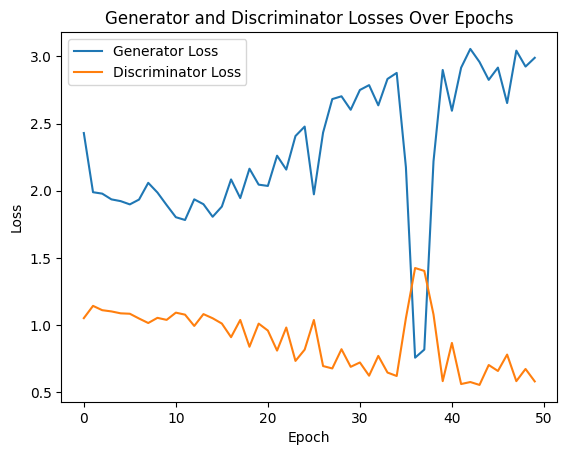

In [6]:
plt.plot(range(num_epochs), g_losses, label="Generator Loss")
plt.plot(range(num_epochs), d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Losses Over Epochs")
plt.show()

Compute Overall and Per-Class Attack Success Rate

In [7]:
from collections import defaultdict

target_model = target_model.to(device)

total = 0
correct = 0
attack_success = 0
per_class_total = defaultdict(int)
per_class_success = defaultdict(int)

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)

    adv_images = fast_gradient_method(target_model, images, epsilon, np.inf)

    original_pred = target_model(images).argmax(1)
    adv_pred = target_model(adv_images).argmax(1)


    total += labels.size(0)
    correct += (original_pred == labels).sum().item()
    attack_success += (adv_pred != labels).sum().item()


    for label, o_pred, a_pred in zip(labels, original_pred, adv_pred):
        per_class_total[label.item()] += 1
        if o_pred != a_pred:
            per_class_success[label.item()] += 1


overall_success_rate = (attack_success / total) * 100
per_class_success_rate = {cls: (per_class_success[cls] / per_class_total[cls]) * 100 for cls in per_class_total}

print(f"Overall Attack Success Rate: {overall_success_rate:.2f}%")
print("Per-Class Attack Success Rate:")
for cls, rate in per_class_success_rate.items():
    print(f"Class {cls}: {rate:.2f}%")

Overall Attack Success Rate: 63.14%
Per-Class Attack Success Rate:
Class 3: 77.90%
Class 8: 51.00%
Class 0: 70.80%
Class 6: 84.50%
Class 1: 63.70%
Class 9: 72.30%
Class 5: 84.50%
Class 7: 76.30%
Class 4: 76.80%
Class 2: 80.20%


Visualize 5 Sample Images (Original, Adversarial, Perturbation)

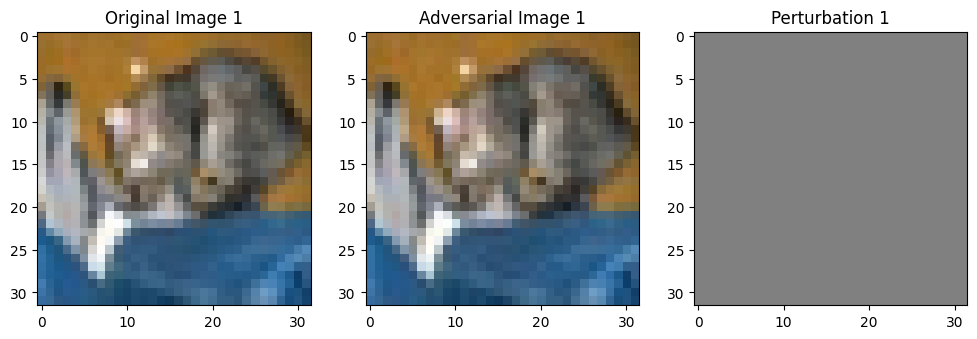

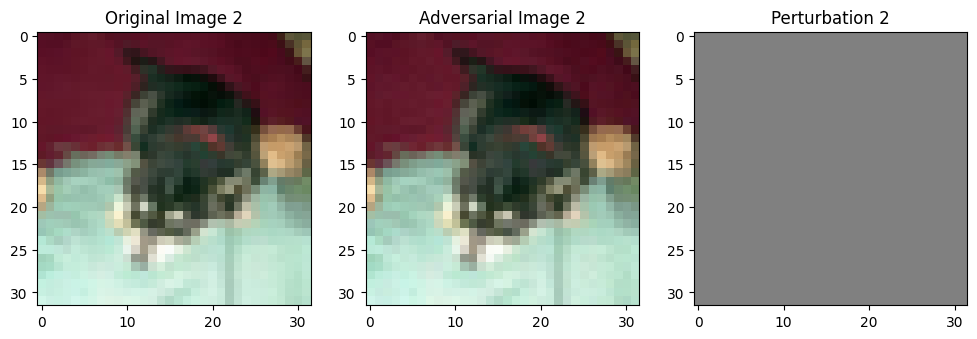

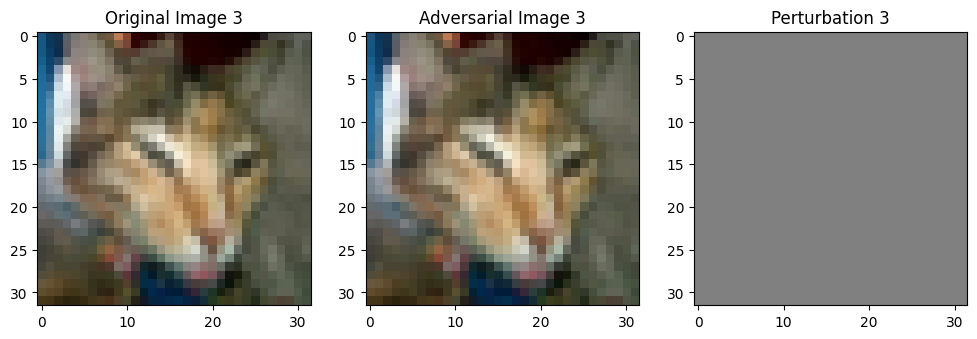

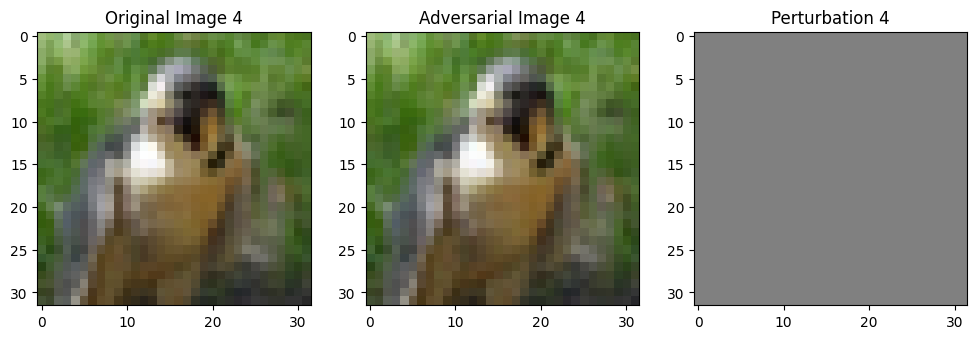

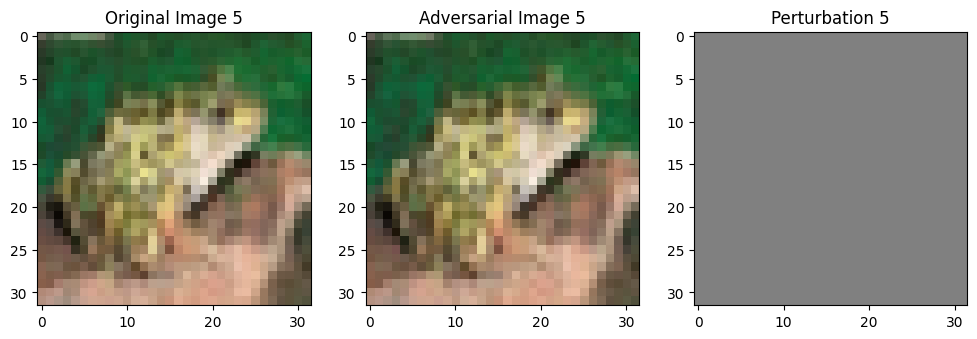

In [8]:
original_images, adversarial_images, perturbations = [], [], []

dataiter = iter(testloader)
for _ in range(5):
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    adv_images = fast_gradient_method(target_model, images, epsilon, np.inf)

    original_images.append(images[0])
    adversarial_images.append(adv_images[0])
    perturbations.append((adv_images[0] - images[0]).abs())

for i in range(5):
    show_images(original_images[i], adversarial_images[i], perturbations[i], i)

Plot Histograms of Model Confidence

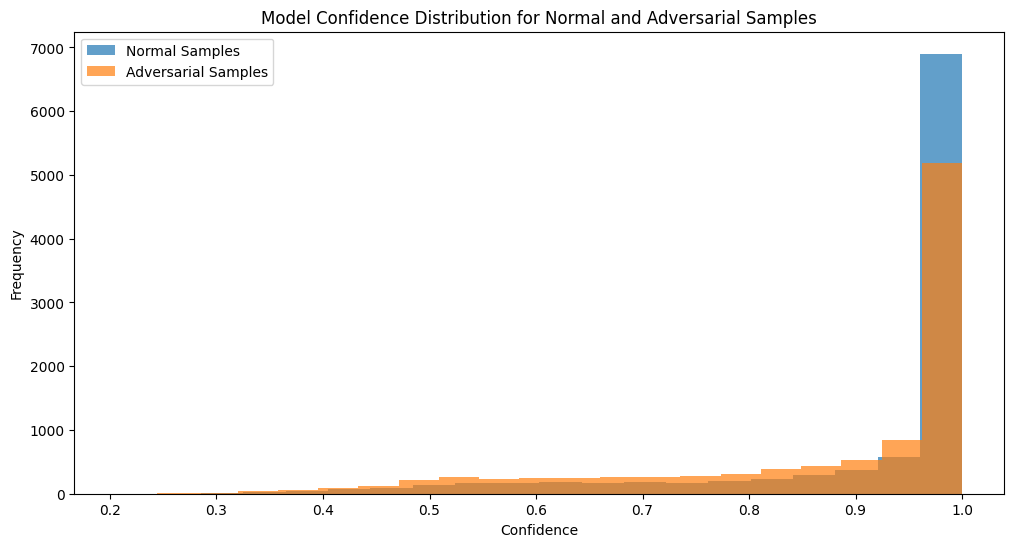

In [9]:
normal_confidences = []
adversarial_confidences = []

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    adv_images = fast_gradient_method(target_model, images, epsilon, np.inf)
    normal_outputs = target_model(images)
    adv_outputs = target_model(adv_images)
    normal_confidences.extend(torch.softmax(normal_outputs, dim=1).max(1).values.detach().cpu().numpy())
    adversarial_confidences.extend(torch.softmax(adv_outputs, dim=1).max(1).values.detach().cpu().numpy())


plt.figure(figsize=(12, 6))
plt.hist(normal_confidences, bins=20, alpha=0.7, label="Normal Samples")
plt.hist(adversarial_confidences, bins=20, alpha=0.7, label="Adversarial Samples")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Model Confidence Distribution for Normal and Adversarial Samples")
plt.legend()
plt.show()

Generate Targeted Adversarial Examples

In [10]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

def targeted_adversarial_examples(model, images, target_labels, epsilon):
    images.requires_grad = True
    outputs = model(images)

    target_one_hot = F.one_hot(target_labels, num_classes=10).float().to(device)
    loss = -torch.sum(target_one_hot * F.log_softmax(outputs, dim=1), dim=1).mean()

    model.zero_grad()
    loss.backward()
    adv_images = images + epsilon * images.grad.sign()
    adv_images = torch.clamp(adv_images, 0, 1)
    return adv_images

 Evaluate Targeted Attack

In [11]:
total = 0
targeted_success = 0
per_class_targeted_success = defaultdict(int)
per_class_targeted_total = defaultdict(int)

target_class = 0

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    target_labels = torch.full_like(labels, target_class)

    adv_images = targeted_adversarial_examples(target_model, images, target_labels, epsilon)

    adv_pred = target_model(adv_images).argmax(1)

    total += labels.size(0)
    targeted_success += (adv_pred == target_labels).sum().item()

    for label, t_pred in zip(labels, adv_pred):
        per_class_targeted_total[label.item()] += 1
        if t_pred == target_class:
            per_class_targeted_success[label.item()] += 1

overall_targeted_success_rate = (targeted_success / total) * 100
per_class_targeted_success_rate = {cls: (per_class_targeted_success[cls] / per_class_targeted_total[cls]) * 100 for cls in per_class_targeted_total}

print(f"Overall Targeted Attack Success Rate: {overall_targeted_success_rate:.2f}%")
print("Per-Class Targeted Attack Success Rate:")
for cls, rate in per_class_targeted_success_rate.items():
    print(f"Class {cls}: {rate:.2f}%")

Overall Targeted Attack Success Rate: 16.02%
Per-Class Targeted Attack Success Rate:
Class 3: 8.80%
Class 8: 5.30%
Class 0: 48.60%
Class 6: 15.60%
Class 1: 20.60%
Class 9: 14.40%
Class 5: 4.70%
Class 7: 11.20%
Class 4: 16.90%
Class 2: 14.10%


Visualize Samples (Targeted Attack)

Original Label: 6, Target Class: 0


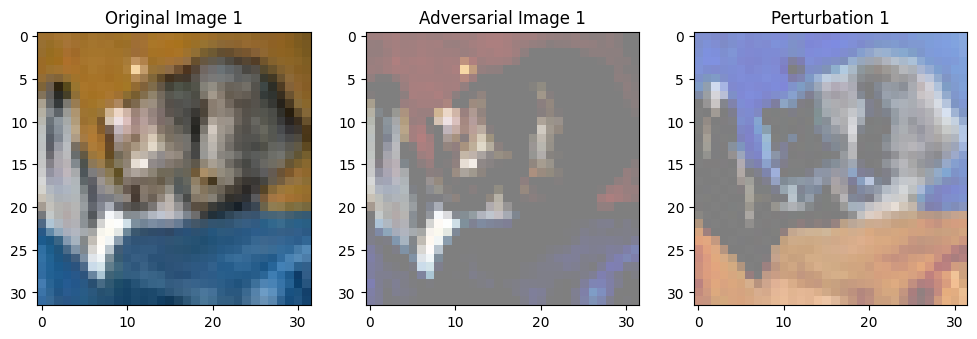

Original Label: 1, Target Class: 0


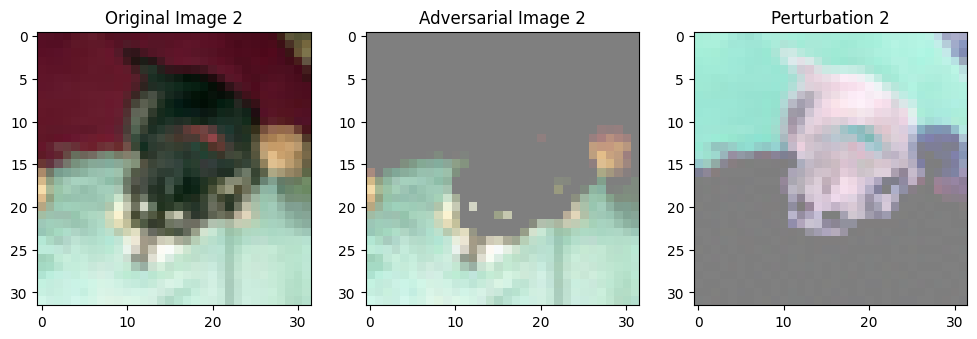

Original Label: 5, Target Class: 0


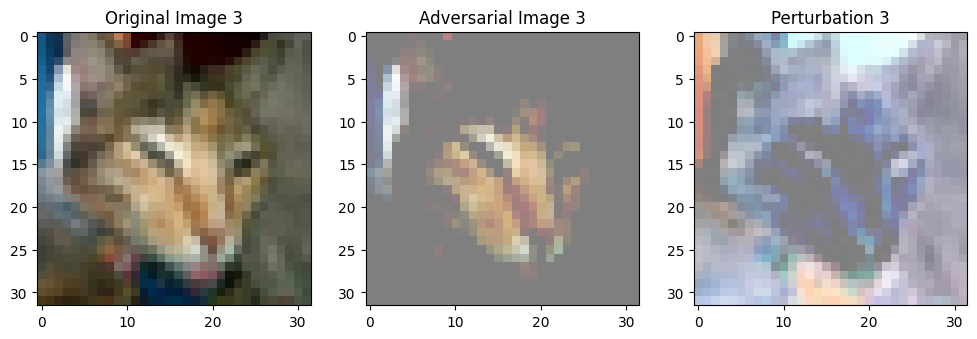

Original Label: 3, Target Class: 0


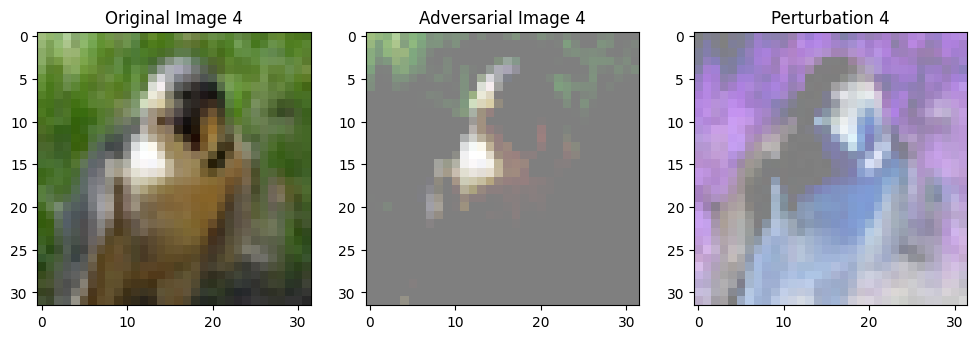

Original Label: 8, Target Class: 0


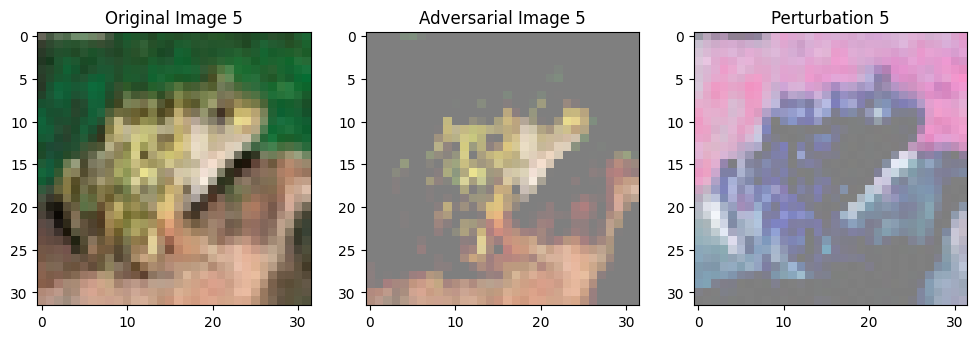

In [12]:
original_images, adversarial_images, target_classes = [], [], []

dataiter = iter(testloader)
for _ in range(5):
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    target_labels = torch.full_like(labels, target_class)

    adv_images = targeted_adversarial_examples(target_model, images, target_labels, epsilon)

    original_images.append(images[0])
    adversarial_images.append(adv_images[0])
    target_classes.append(target_class)

for i in range(5):
    print(f"Original Label: {labels[i].item()}, Target Class: {target_classes[i]}")
    show_images(original_images[i], adversarial_images[i], adversarial_images[i] - original_images[i], i)

Plot Histograms of Model Confidence (Targeted Attack)

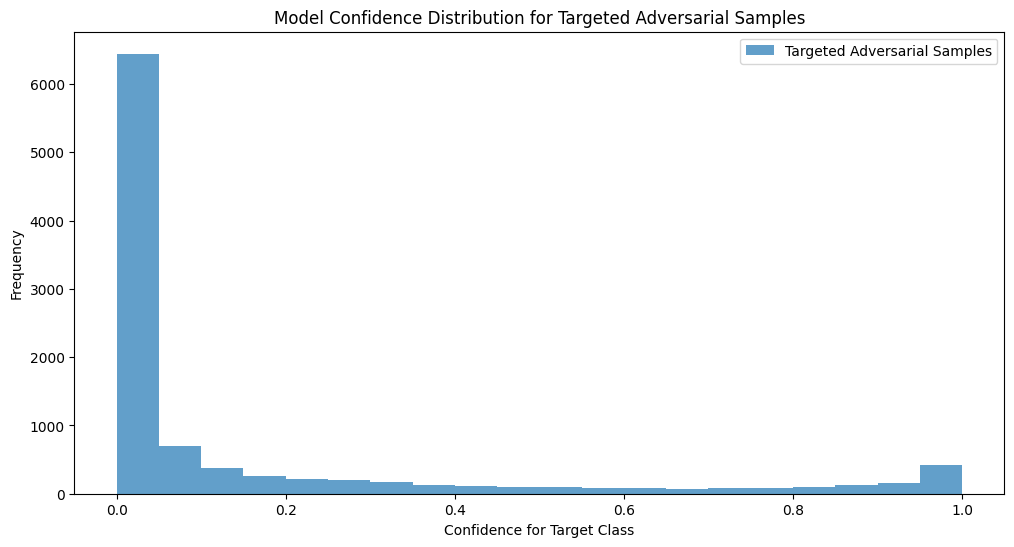

In [13]:
targeted_confidences = []

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    target_labels = torch.full_like(labels, target_class)
    adv_images = targeted_adversarial_examples(target_model, images, target_labels, epsilon)
    adv_outputs = target_model(adv_images)
    targeted_confidences.extend(torch.softmax(adv_outputs, dim=1)[:, target_class].detach().cpu().numpy())

plt.figure(figsize=(12, 6))
plt.hist(targeted_confidences, bins=20, alpha=0.7, label="Targeted Adversarial Samples")
plt.xlabel("Confidence for Target Class")
plt.ylabel("Frequency")
plt.title("Model Confidence Distribution for Targeted Adversarial Samples")
plt.legend()
plt.show()

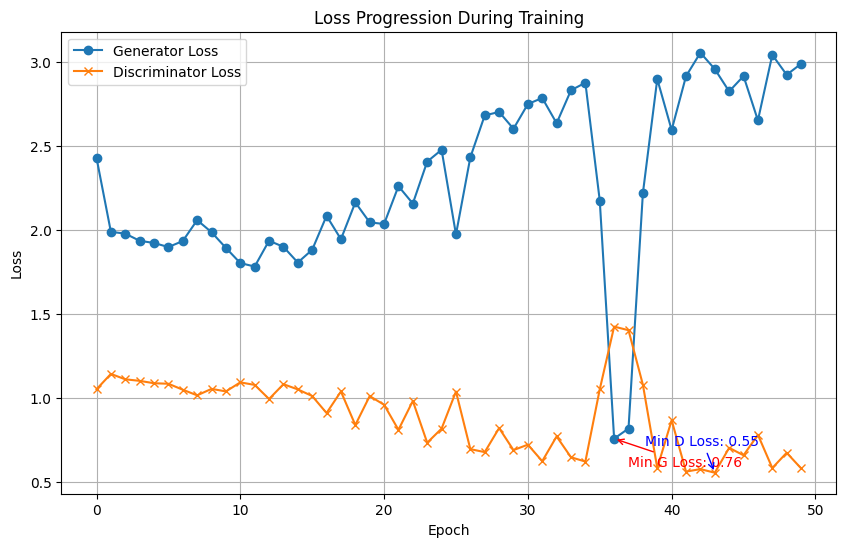

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), g_losses, label="Generator Loss", marker='o')
plt.plot(range(num_epochs), d_losses, label="Discriminator Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Progression During Training")
plt.legend()
plt.grid(True)

min_g_loss = min(g_losses)
max_g_loss = max(g_losses)
plt.annotate(f"Min G Loss: {min_g_loss:.2f}", xy=(g_losses.index(min_g_loss), min_g_loss), xytext=(10, -20),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'), color='red')

min_d_loss = min(d_losses)
max_d_loss = max(d_losses)
plt.annotate(f"Min D Loss: {min_d_loss:.2f}", xy=(d_losses.index(min_d_loss), min_d_loss), xytext=(-50, 20),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='blue'), color='blue')

plt.show()

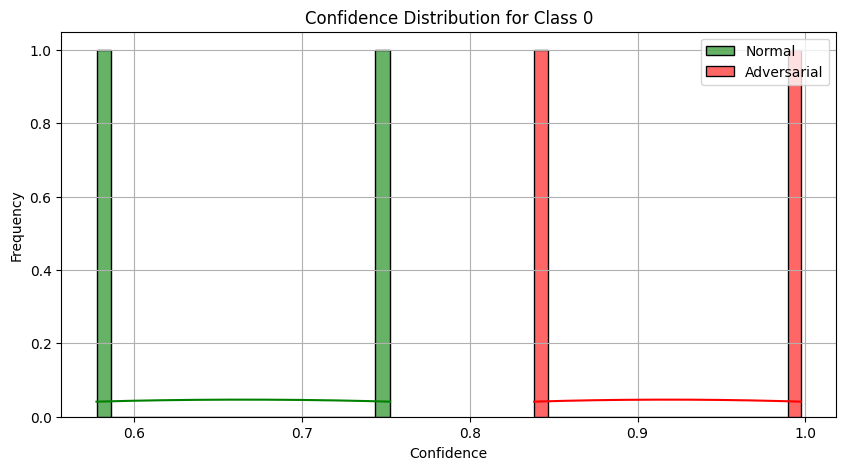

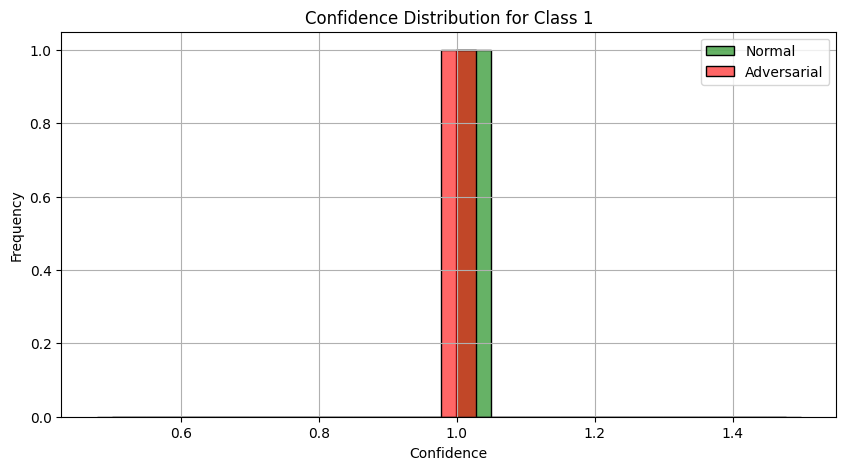

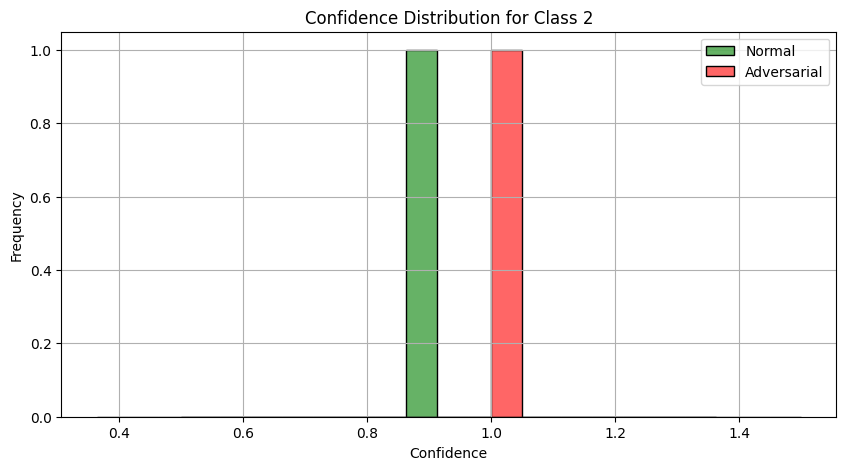

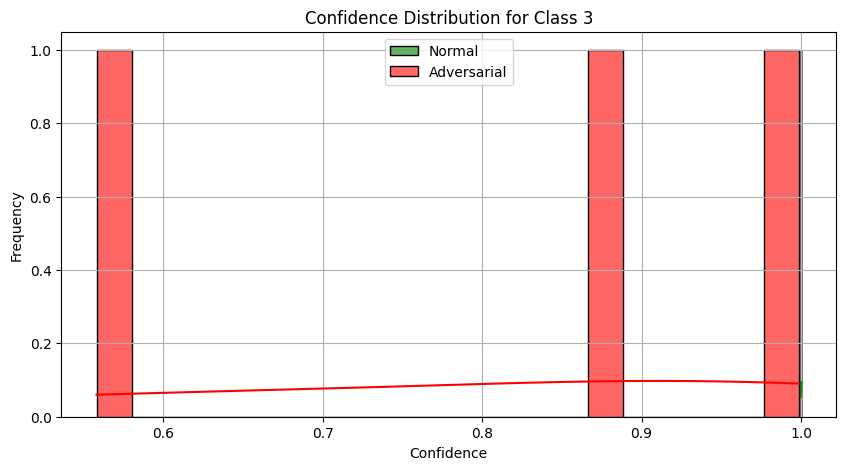

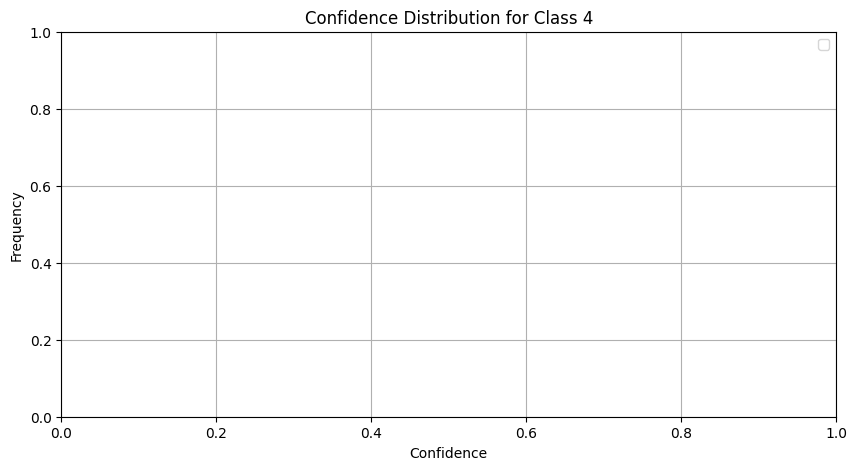

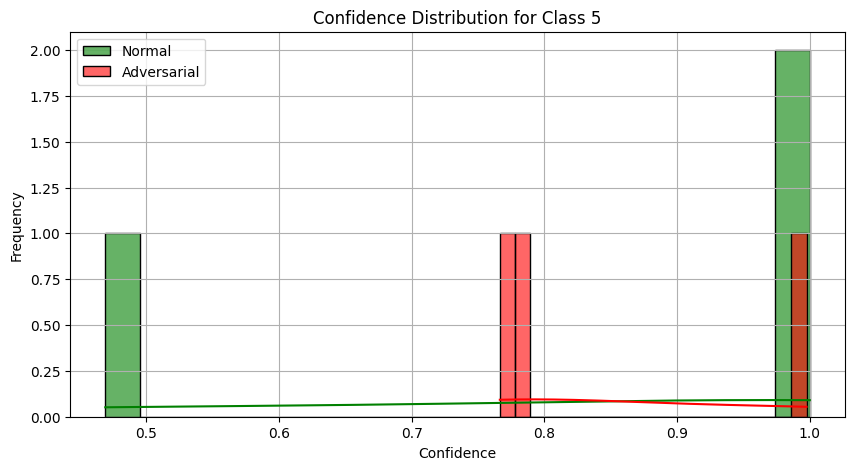

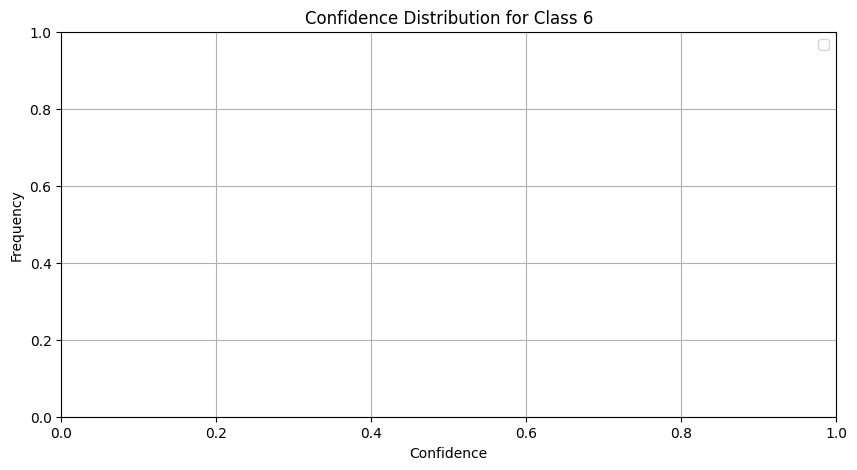

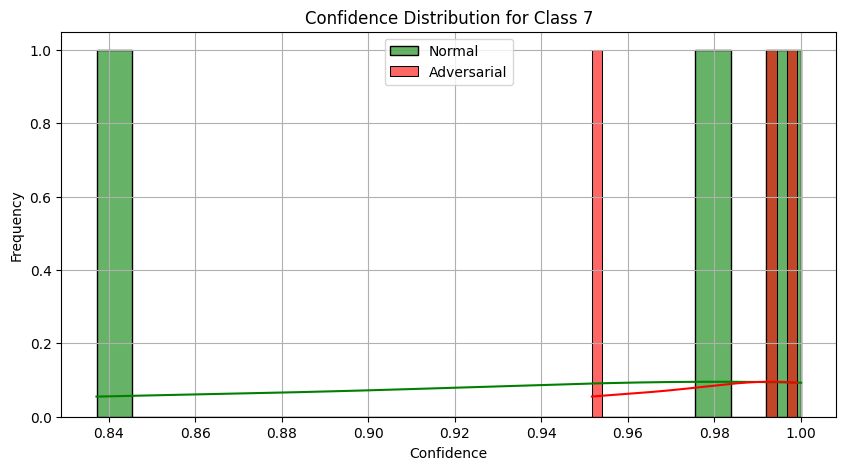

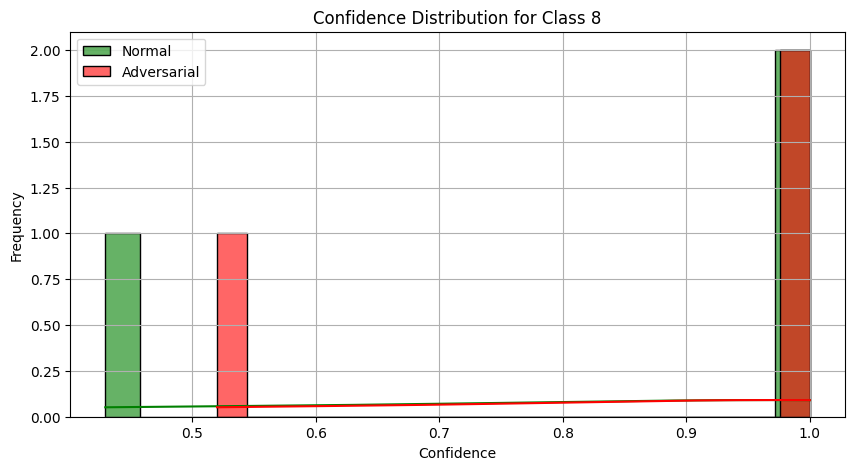

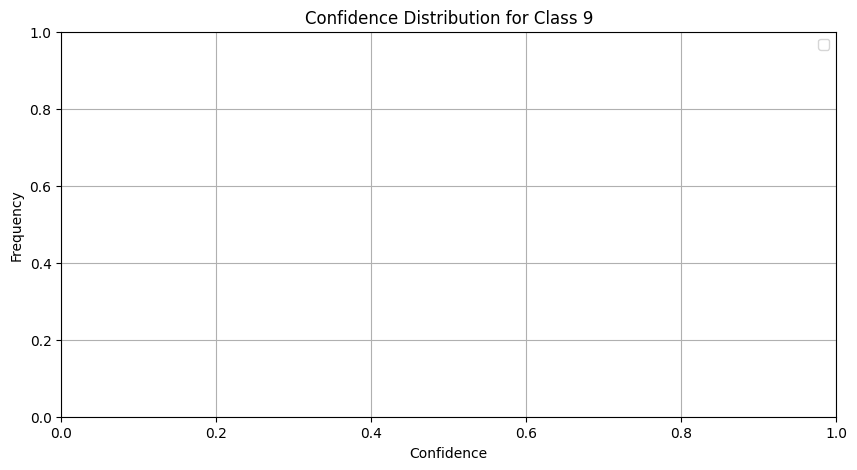

In [15]:
for cls in range(10):
    cls_conf_normal = [conf for img, lbl, conf in zip(images, labels, normal_confidences) if lbl == cls]
    cls_conf_adv = [conf for img, lbl, conf in zip(images, labels, adversarial_confidences) if lbl == cls]

    plt.figure(figsize=(10, 5))
    sns.histplot(cls_conf_normal, bins=20, kde=True, label="Normal", color='green', alpha=0.6)
    sns.histplot(cls_conf_adv, bins=20, kde=True, label="Adversarial", color='red', alpha=0.6)
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.title(f"Confidence Distribution for Class {cls}")
    plt.legend()
    plt.grid(True)
    plt.show()

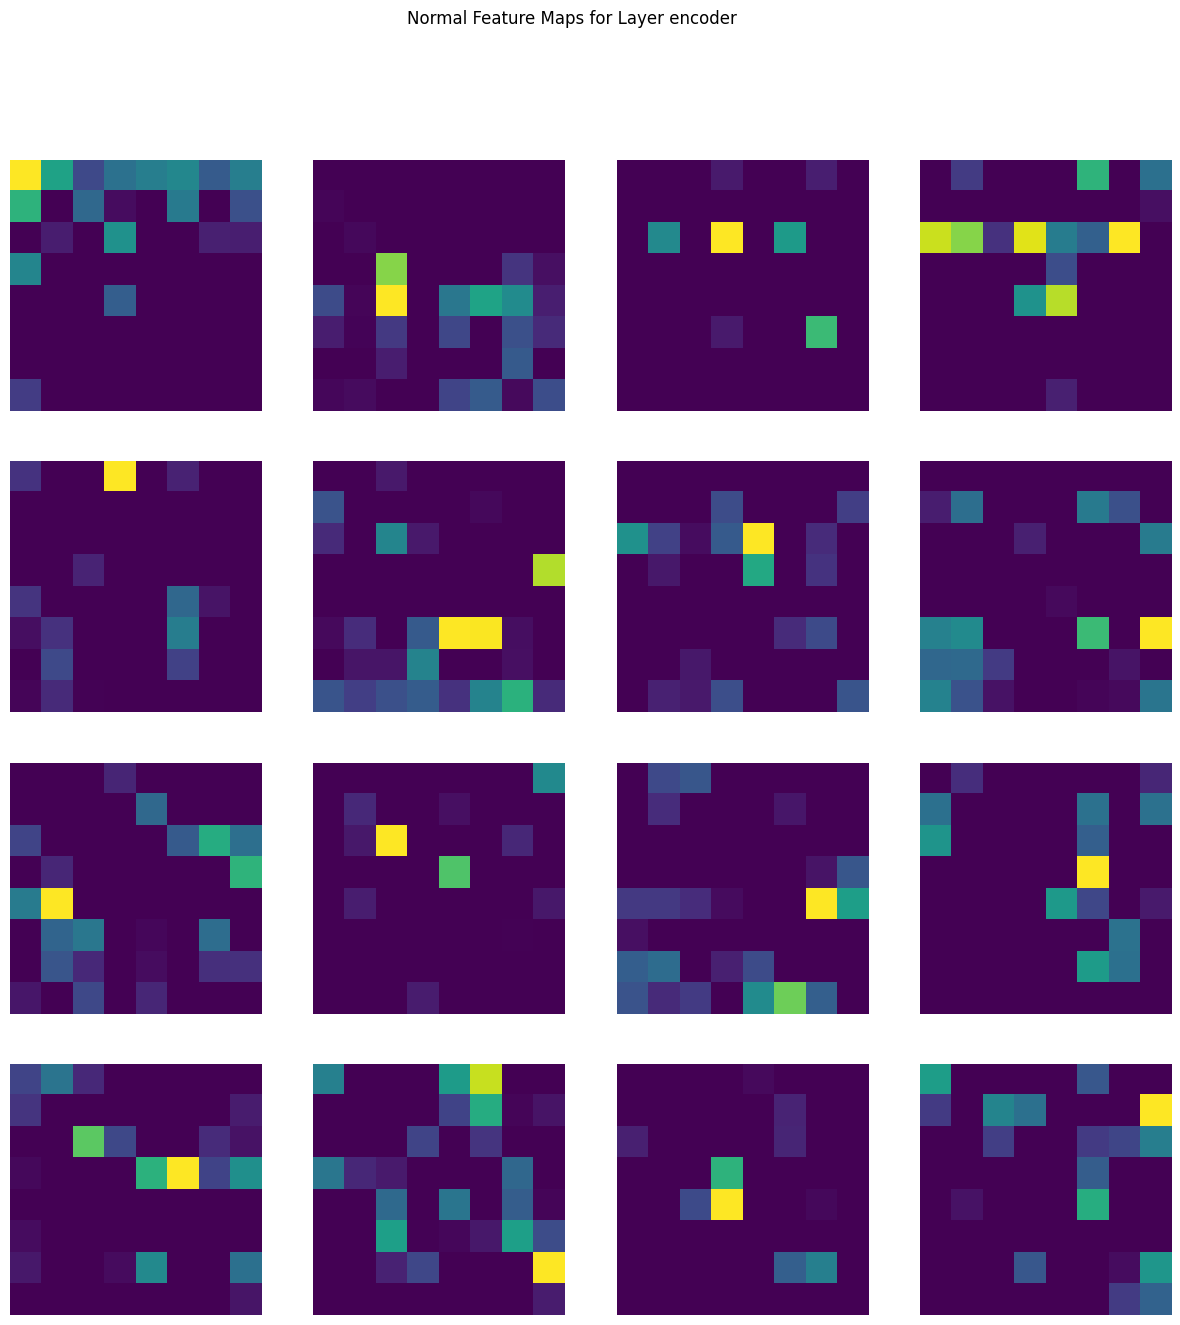

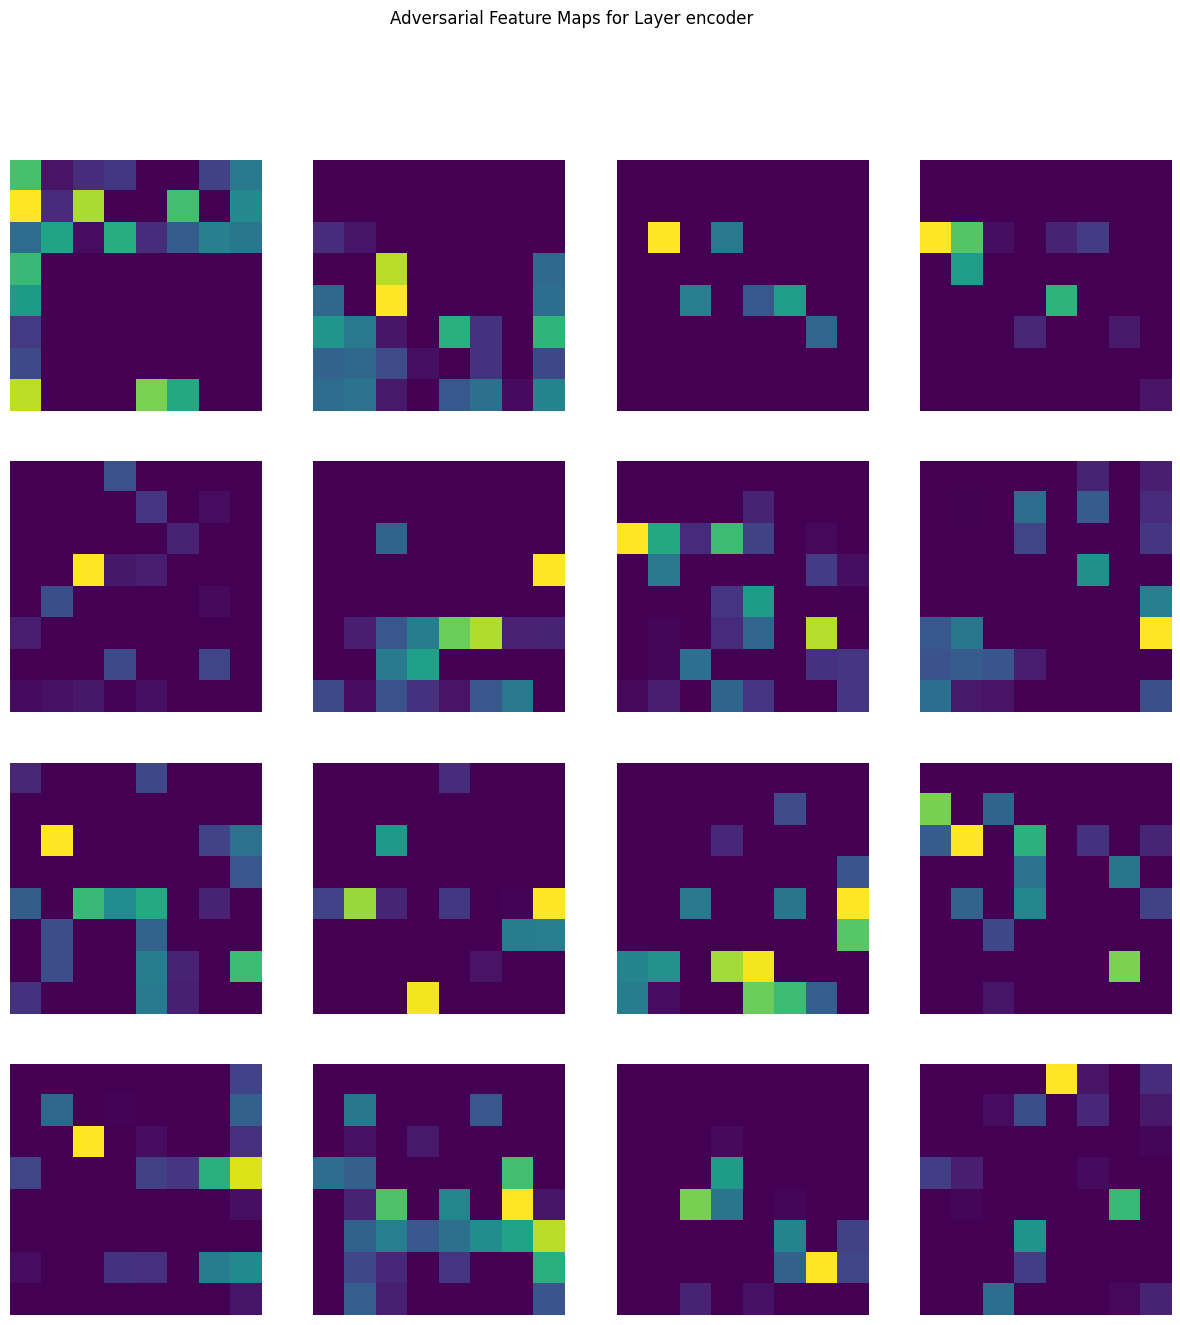

In [16]:
def visualize_feature_maps(model, layer_name, image, title_prefix):
    layer = dict(model.named_children())[layer_name]
    hook_outputs = []

    def hook_fn(module, input, output):
        hook_outputs.append(output)

    hook = layer.register_forward_hook(hook_fn)
    model(image.unsqueeze(0))
    hook.remove()

    feature_maps = hook_outputs[0].detach().cpu()
    n_features = feature_maps.shape[1]
    plt.figure(figsize=(15, 15))
    for i in range(min(n_features, 16)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_maps[0, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"{title_prefix} Feature Maps for Layer {layer_name}")
    plt.show()

visualize_feature_maps(generator, 'encoder', images[0], "Normal")
visualize_feature_maps(generator, 'encoder', adv_images[0], "Adversarial")

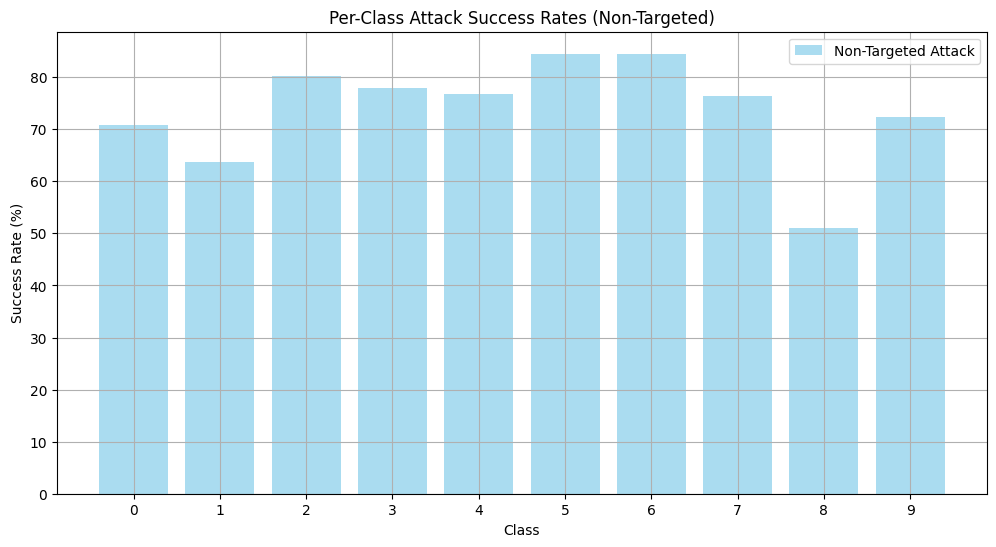

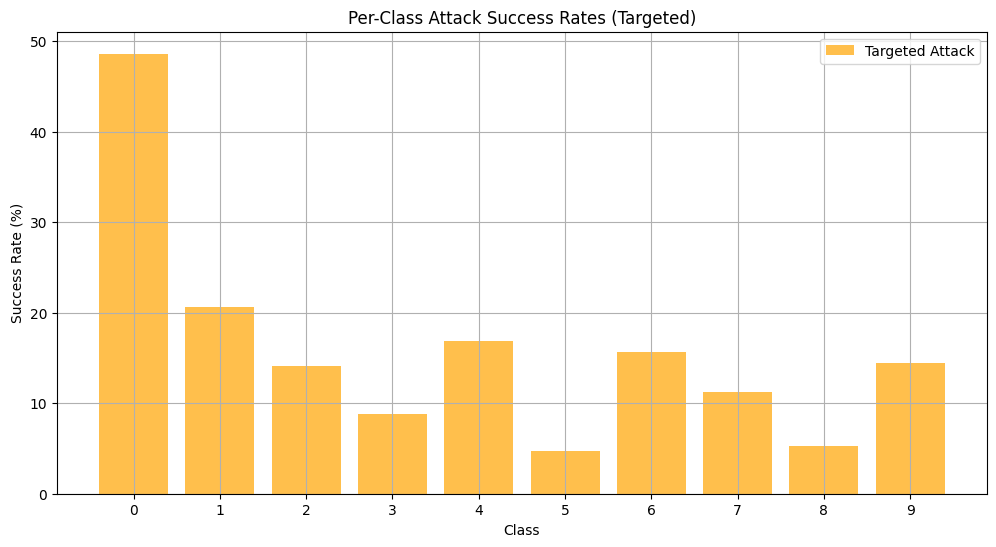

In [17]:
classes = list(per_class_success_rate.keys())
rates = list(per_class_success_rate.values())

plt.figure(figsize=(12, 6))
plt.bar(classes, rates, color='skyblue', alpha=0.7, label="Non-Targeted Attack")
plt.xlabel("Class")
plt.ylabel("Success Rate (%)")
plt.title("Per-Class Attack Success Rates (Non-Targeted)")
plt.xticks(classes)
plt.grid(True)
plt.legend()
plt.show()

rates_targeted = list(per_class_targeted_success_rate.values())

plt.figure(figsize=(12, 6))
plt.bar(classes, rates_targeted, color='orange', alpha=0.7, label="Targeted Attack")
plt.xlabel("Class")
plt.ylabel("Success Rate (%)")
plt.title("Per-Class Attack Success Rates (Targeted)")
plt.xticks(classes)
plt.grid(True)
plt.legend()
plt.show()